In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from random import sample
import scipy
import sklearn.utils
from itertools import chain

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
import sklearn.model_selection as skl
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint,LearningRateScheduler,EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam,SGD
from sklearn.metrics import roc_curve,auc,precision_recall_curve,average_precision_score,plot_precision_recall_curve,f1_score,confusion_matrix

In [2]:
import keras

print(keras.__version__)


2.4.3


In [2]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())

True


In [4]:
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)

2.3.0
2.4.0


In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6164086944749062041
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9621912640035426277
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4951408640
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13212064862524054028
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2698061258356429974
physical_device_desc: "device: XLA_GPU device"
]


In [2]:
all_plants_df = pd.read_csv('kaggle-leaf/train.csv')
all_plants_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [3]:
all_image_paths = {os.path.basename(x):x for x in glob(os.path.join('kaggle-leaf','train_images','*.jpg'))}
len(all_image_paths)

21397

In [4]:
all_plants_df['path'] = all_plants_df['image_id'].map(all_image_paths.get)
all_plants_df.sample(3)

,image_id,label,path
4048,1721767789.jpg,3,kaggle-leaf\train_images\1721767789.jpg
12339,3211556241.jpg,3,kaggle-leaf\train_images\3211556241.jpg
12071,31623252.jpg,1,kaggle-leaf\train_images\31623252.jpg


In [13]:
all_labels = np.unique(list(all_plants_df['label']))

In [14]:
all_labels

array([0, 1, 2, 3, 4])

In [16]:
all_plants_df.loc[all_plants_df['label'] == 2]

,image_id,label,path
6,1000910826.jpg,2,kaggle-leaf\train_images\1000910826.jpg
15,1003218714.jpg,2,kaggle-leaf\train_images\1003218714.jpg
24,100472565.jpg,2,kaggle-leaf\train_images\100472565.jpg
25,1004826518.jpg,2,kaggle-leaf\train_images\1004826518.jpg
28,1005200906.jpg,2,kaggle-leaf\train_images\1005200906.jpg
...,...,...,...
21329,984892057.jpg,2,kaggle-leaf\train_images\984892057.jpg
21374,995155483.jpg,2,kaggle-leaf\train_images\995155483.jpg
21381,996947690.jpg,2,kaggle-leaf\train_images\996947690.jpg
21385,997289539.jpg,2,kaggle-leaf\train_images\997289539.jpg


In [6]:
df = all_plants_df.groupby(['label']).size().reset_index(name='counts')
df

,label,counts
0,0,1087
1,1,2189
2,2,2386
3,3,13158
4,4,2577


In [7]:
all_plants_df_shuffled = sklearn.utils.shuffle(all_plants_df)
df1 = all_plants_df_shuffled[2:]['path'].astype(str)
val = df1.reset_index(drop=True)
path1 = val.get(0)

In [20]:
path1

'kaggle-leaf\\train_images\\3473125611.jpg'

In [21]:
img = mpimg.imread(path1)

In [22]:
from PIL import Image

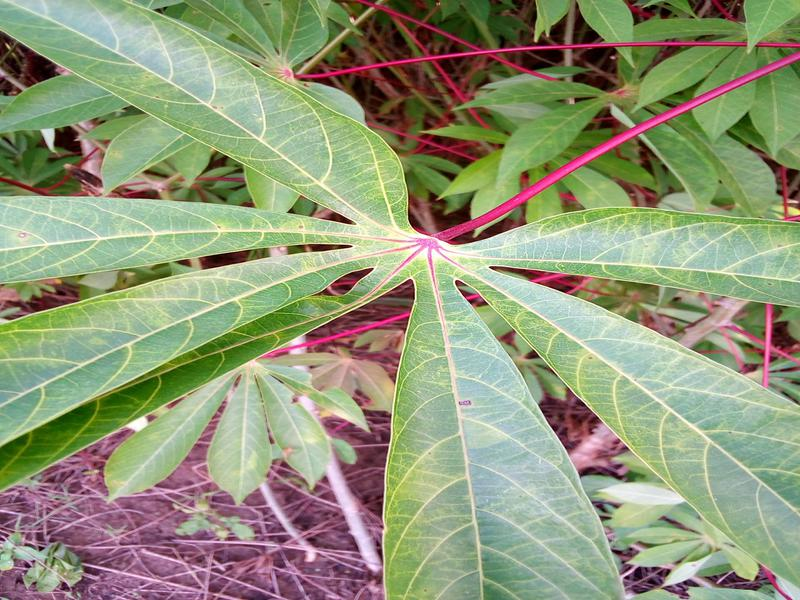

In [23]:
image = Image.open(path1)
image

In [24]:
img.shape

(600, 800, 3)

In [70]:
from numpy import asarray
data = asarray(image)

(array([20571.,  3489.,  3625.,  4087.,  4391.,  4621.,  5050.,  5331.,
         5583.,  5743.,  6230.,  6715.,  7102.,  7493.,  7747.,  8227.,
         8914.,  9149.,  9428.,  9781., 10268., 10314., 10729., 10757.,
        11479., 11438., 11712., 11813., 11773., 11925., 11702., 12064.,
        11947., 11878., 11752., 11772., 11662., 11789., 11753., 11621.,
        11708., 11550., 11671., 11376., 11410., 11624., 11478., 11582.,
        11525., 11304., 11311., 11344., 11020., 11263., 11192., 10955.,
        10733., 10669., 10544., 10365., 10480., 10390., 10233., 10160.,
        10188., 10195., 10279., 10180.,  9983., 10188.,  9942., 10098.,
         9927., 10096., 10053.,  9788.,  9607.,  9531.,  9552.,  9572.,
         9426.,  9340.,  9417.,  9275.,  9038.,  8921.,  8992.,  9031.,
         8866.,  8619.,  8577.,  8570.,  8369.,  8207.,  8087.,  7899.,
         7741.,  7438.,  7394.,  7354.,  7134.,  7114.,  6920.,  6677.,
         6754.,  6639.,  6492.,  6499.,  6202.,  6378.,  6158., 

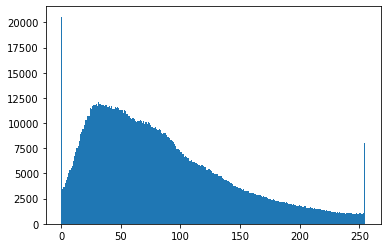

In [71]:
plt.hist(data.ravel(),bins=256)

Training Data and Testing Data. first create a model to classify class 3 and rest. 

In [9]:
all_plants_df_shuffled.head()

,image_id,label,path
5623,1999385559.jpg,3,kaggle-leaf\train_images\1999385559.jpg
8095,2435788623.jpg,2,kaggle-leaf\train_images\2435788623.jpg
14197,3536394674.jpg,1,kaggle-leaf\train_images\3536394674.jpg
514,1091529167.jpg,3,kaggle-leaf\train_images\1091529167.jpg
18621,482335767.jpg,2,kaggle-leaf\train_images\482335767.jpg


In [8]:
all_plants_df_shuffled['label3'] = all_plants_df_shuffled['label']

C:\Users\sum_c\anaconda3\envs\GpuEnv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
all_plants_df_shuffled.head()

,image_id,label,path,label3
5623,1999385559.jpg,3,kaggle-leaf\train_images\1999385559.jpg,3
8095,2435788623.jpg,2,kaggle-leaf\train_images\2435788623.jpg,2
14197,3536394674.jpg,1,kaggle-leaf\train_images\3536394674.jpg,1
514,1091529167.jpg,3,kaggle-leaf\train_images\1091529167.jpg,3
18621,482335767.jpg,2,kaggle-leaf\train_images\482335767.jpg,2


In [48]:
#plants_label_0 = all_plants_df_shuffled.where(all_plants_df_shuffled["label3"] == 3)

In [58]:
#plants_1 = all_plants_df_shuffled.loc[all_plants_df_shuffled["label3"] == 1] 

In [59]:
#plants_2 = all_plants_df_shuffled.loc[all_plants_df_shuffled["label3"] == 2]

In [60]:
#plants_4 = all_plants_df_shuffled.loc[all_plants_df_shuffled["label3"] == 4]

In [61]:
#plants_0 = all_plants_df_shuffled.loc[all_plants_df_shuffled["label3"] == 0]

In [62]:
#plants_3 = all_plants_df_shuffled.loc[all_plants_df_shuffled["label3"] == 3]

In [64]:
#plants_3_additional = plants_3[0:3320]

In [10]:
all_plants = all_plants_df_shuffled

# 

In [11]:
df1 = all_plants.groupby(['label3']).size().reset_index(name='counts')

In [28]:
df1

,label3,counts
0,0,1087
1,1,2189
2,2,2386
3,3,13158
4,4,2577


separate all_plants_df_shuffled into train test 

In [12]:
all_plants_df_shuffled['class3'] = all_plants_df_shuffled['label']

C:\Users\sum_c\anaconda3\envs\GpuEnv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
train_df,valid_df = skl.train_test_split(all_plants_df_shuffled,test_size=0.2,stratify=all_plants_df_shuffled['class3'])

In [13]:
train_df

,image_id,label,path,label3,class3
3544,162469739.jpg,3,kaggle-leaf\train_images\162469739.jpg,3,3
6952,2242503873.jpg,3,kaggle-leaf\train_images\2242503873.jpg,3,3
457,1080752639.jpg,1,kaggle-leaf\train_images\1080752639.jpg,1,1
157,1027766963.jpg,3,kaggle-leaf\train_images\1027766963.jpg,3,3
12976,3323187538.jpg,2,kaggle-leaf\train_images\3323187538.jpg,2,2
...,...,...,...,...,...
12444,323035134.jpg,2,kaggle-leaf\train_images\323035134.jpg,2,2
17332,412390858.jpg,2,kaggle-leaf\train_images\412390858.jpg,2,2
6584,2179468784.jpg,3,kaggle-leaf\train_images\2179468784.jpg,3,3
1268,1221540590.jpg,3,kaggle-leaf\train_images\1221540590.jpg,3,3


In [37]:
valid_df

,image_id,label,path,class3
3096,1536785739.jpg,3,kaggle-leaf\train_images\1536785739.jpg,3
8,1001723730.jpg,4,kaggle-leaf\train_images\1001723730.jpg,4
1143,1198476572.jpg,4,kaggle-leaf\train_images\1198476572.jpg,4
18369,440065824.jpg,3,kaggle-leaf\train_images\440065824.jpg,3
3537,1623025307.jpg,3,kaggle-leaf\train_images\1623025307.jpg,3
...,...,...,...,...
1237,1215607589.jpg,3,kaggle-leaf\train_images\1215607589.jpg,3
1889,1333580402.jpg,0,kaggle-leaf\train_images\1333580402.jpg,0
14154,3529056691.jpg,3,kaggle-leaf\train_images\3529056691.jpg,3
20382,804506814.jpg,3,kaggle-leaf\train_images\804506814.jpg,3


In [14]:
df_train = train_df.groupby(['label']).size().reset_index(name='counts')
df_train

,label,counts
0,0,870
1,1,1751
2,2,1909
3,3,10526
4,4,2061


In [15]:
#balance the training dataset by data augmenting. double the records with label 0
df_plants_class0 = train_df.loc[train_df["class3"] == 0] 

train_df = train_df.append(df_plants_class0).reset_index()


In [17]:
train_df

,index,image_id,label,path,label3,class3
0,3544,162469739.jpg,3,kaggle-leaf\train_images\162469739.jpg,3,3
1,6952,2242503873.jpg,3,kaggle-leaf\train_images\2242503873.jpg,3,3
2,457,1080752639.jpg,1,kaggle-leaf\train_images\1080752639.jpg,1,1
3,157,1027766963.jpg,3,kaggle-leaf\train_images\1027766963.jpg,3,3
4,12976,3323187538.jpg,2,kaggle-leaf\train_images\3323187538.jpg,2,2
...,...,...,...,...,...,...
17982,1046,1179913576.jpg,0,kaggle-leaf\train_images\1179913576.jpg,0,0
17983,18840,519050764.jpg,0,kaggle-leaf\train_images\519050764.jpg,0,0
17984,13929,3489692619.jpg,0,kaggle-leaf\train_images\3489692619.jpg,0,0
17985,12855,3302044032.jpg,0,kaggle-leaf\train_images\3302044032.jpg,0,0


In [16]:
class0_inds = train_df[train_df["class3"] == 0].index.tolist()
class0_sample = sample(class0_inds,891)
class0_balanced_df = train_df.loc[class0_sample]
class0_balanced_df

,index,image_id,label,path,label3,class3
17273,15436,377552461.jpg,0,kaggle-leaf\train_images\377552461.jpg,0,0
17775,17972,4237476054.jpg,0,kaggle-leaf\train_images\4237476054.jpg,0,0
17558,8581,2522350885.jpg,0,kaggle-leaf\train_images\2522350885.jpg,0,0
8431,13716,3454772304.jpg,0,kaggle-leaf\train_images\3454772304.jpg,0,0
17525,16416,3955391972.jpg,0,kaggle-leaf\train_images\3955391972.jpg,0,0
...,...,...,...,...,...,...
12651,6569,2177675284.jpg,0,kaggle-leaf\train_images\2177675284.jpg,0,0
17490,9197,2626785894.jpg,0,kaggle-leaf\train_images\2626785894.jpg,0,0
7490,15138,3719374465.jpg,0,kaggle-leaf\train_images\3719374465.jpg,0,0
11062,243,1044718671.jpg,0,kaggle-leaf\train_images\1044718671.jpg,0,0


In [17]:
train_df = train_df.append(class0_balanced_df).reset_index()

In [18]:
class1_inds = train_df[train_df["class3"] == 1].index.tolist()
class1_sample = sample(class1_inds,880)
class1_balanced_df = train_df.loc[class1_sample]




In [19]:
train_df = train_df.append(class1_balanced_df)

In [20]:
class2_inds = train_df[train_df["class3"] == 2].index.tolist()
class2_sample = sample(class2_inds,722)
class2_balanced_df = train_df.loc[class2_sample]

In [21]:
train_df = train_df.append(class2_balanced_df)

In [22]:
class4_inds = train_df[train_df["class3"] == 4].index.tolist()
class4_sample = sample(class4_inds,572)
class4_balanced_df = train_df.loc[class4_sample]

In [23]:
train_df = train_df.append(class4_balanced_df)

In [23]:
train_df

,level_0,index,image_id,label,path,label3,class3
0,0,11845,3118293114.jpg,4,kaggle-leaf\train_images\3118293114.jpg,4,4
1,1,18105,426011031.jpg,3,kaggle-leaf\train_images\426011031.jpg,3,3
2,2,16181,3914861285.jpg,3,kaggle-leaf\train_images\3914861285.jpg,3,3
3,3,10478,2869590198.jpg,3,kaggle-leaf\train_images\2869590198.jpg,3,3
4,4,8732,2547653381.jpg,3,kaggle-leaf\train_images\2547653381.jpg,3,3
...,...,...,...,...,...,...,...
6877,6877,18732,499934842.jpg,4,kaggle-leaf\train_images\499934842.jpg,4,4
5789,5789,1660,1290330052.jpg,4,kaggle-leaf\train_images\1290330052.jpg,4,4
1003,1003,5136,1916970860.jpg,4,kaggle-leaf\train_images\1916970860.jpg,4,4
9824,9824,5572,1991094852.jpg,4,kaggle-leaf\train_images\1991094852.jpg,4,4


In [24]:
train_df.loc[(train_df["class3"]== 1) | (train_df["class3"]== 2) | (train_df["class3"]== 4) | (train_df["class3"]== 0),"class3"] = 0

In [25]:
train_df.loc[(train_df["class3"]== 3),"class3"] = 1

In [26]:
df1 = train_df.groupby(['class3']).size().reset_index(name='counts')

In [27]:
df1

,class3,counts
0,0,10526
1,1,10526


In [28]:
train_df.head()

,level_0,index,image_id,label,path,label3,class3
0,0,11845,3118293114.jpg,4,kaggle-leaf\train_images\3118293114.jpg,4,0
1,1,18105,426011031.jpg,3,kaggle-leaf\train_images\426011031.jpg,3,1
2,2,16181,3914861285.jpg,3,kaggle-leaf\train_images\3914861285.jpg,3,1
3,3,10478,2869590198.jpg,3,kaggle-leaf\train_images\2869590198.jpg,3,1
4,4,8732,2547653381.jpg,3,kaggle-leaf\train_images\2547653381.jpg,3,1


In [28]:
train_df["class3_disease"] = train_df['class3']
train_df.head()

,level_0,index,image_id,label,path,label3,class3,class3_disease
0,0,5645,2003165329.jpg,3,kaggle-leaf\train_images\2003165329.jpg,3,1,1
1,1,6753,2208145529.jpg,2,kaggle-leaf\train_images\2208145529.jpg,2,0,0
2,2,21094,939534770.jpg,3,kaggle-leaf\train_images\939534770.jpg,3,1,1
3,3,7119,2270851426.jpg,0,kaggle-leaf\train_images\2270851426.jpg,0,0,0
4,4,1636,1286828340.jpg,3,kaggle-leaf\train_images\1286828340.jpg,3,1,1


In [29]:
train_df['class3_disease'] = train_df['class3_disease'].map({0:"non-mosaic",1:"mosaic"})

In [30]:
train_df = sklearn.utils.shuffle(train_df)
train_df

,level_0,index,image_id,label,path,label3,class3,class3_disease
15999,15999,10857,2935458232.jpg,3,kaggle-leaf\train_images\2935458232.jpg,3,1,mosaic
7593,7593,11657,3083765507.jpg,3,kaggle-leaf\train_images\3083765507.jpg,3,1,mosaic
13180,13180,10172,281397141.jpg,3,kaggle-leaf\train_images\281397141.jpg,3,1,mosaic
17319,17319,4274,1763195879.jpg,0,kaggle-leaf\train_images\1763195879.jpg,0,0,non-mosaic
11809,11809,5831,2038307832.jpg,3,kaggle-leaf\train_images\2038307832.jpg,3,1,mosaic
...,...,...,...,...,...,...,...,...
1984,1984,2831,1491670235.jpg,3,kaggle-leaf\train_images\1491670235.jpg,3,1,mosaic
14154,14154,14504,3598252026.jpg,3,kaggle-leaf\train_images\3598252026.jpg,3,1,mosaic
15805,15805,13669,344462592.jpg,2,kaggle-leaf\train_images\344462592.jpg,2,0,non-mosaic
10085,10085,16646,3994489797.jpg,2,kaggle-leaf\train_images\3994489797.jpg,2,0,non-mosaic


In [32]:
valid_df

,image_id,label,path,label3,class3
3027,1524561947.jpg,3,kaggle-leaf\train_images\1524561947.jpg,3,3
8584,2523040233.jpg,3,kaggle-leaf\train_images\2523040233.jpg,3,3
5508,1981418117.jpg,3,kaggle-leaf\train_images\1981418117.jpg,3,3
20809,880947570.jpg,3,kaggle-leaf\train_images\880947570.jpg,3,3
17674,4182634633.jpg,3,kaggle-leaf\train_images\4182634633.jpg,3,3
...,...,...,...,...,...
6842,2223402762.jpg,3,kaggle-leaf\train_images\2223402762.jpg,3,3
6857,2225864423.jpg,3,kaggle-leaf\train_images\2225864423.jpg,3,3
5794,2030983872.jpg,2,kaggle-leaf\train_images\2030983872.jpg,2,2
5291,1943654053.jpg,3,kaggle-leaf\train_images\1943654053.jpg,3,3


In [31]:
valid_df["class3_disease"] = valid_df['class3']
valid_df['class3_disease'] = valid_df['class3_disease'].map({0:"non-mosaic",3:"mosaic",2:"non-mosaic",1:"non-mosaic",4:"non-mosaic"})

C:\Users\sum_c\anaconda3\envs\GpuEnv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\sum_c\anaconda3\envs\GpuEnv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
valid_df

,image_id,label,path,label3,class3,class3_disease
3027,1524561947.jpg,3,kaggle-leaf\train_images\1524561947.jpg,3,3,mosaic
8584,2523040233.jpg,3,kaggle-leaf\train_images\2523040233.jpg,3,3,mosaic
5508,1981418117.jpg,3,kaggle-leaf\train_images\1981418117.jpg,3,3,mosaic
20809,880947570.jpg,3,kaggle-leaf\train_images\880947570.jpg,3,3,mosaic
17674,4182634633.jpg,3,kaggle-leaf\train_images\4182634633.jpg,3,3,mosaic
...,...,...,...,...,...,...
6842,2223402762.jpg,3,kaggle-leaf\train_images\2223402762.jpg,3,3,mosaic
6857,2225864423.jpg,3,kaggle-leaf\train_images\2225864423.jpg,3,3,mosaic
5794,2030983872.jpg,2,kaggle-leaf\train_images\2030983872.jpg,2,2,non-mosaic
5291,1943654053.jpg,3,kaggle-leaf\train_images\1943654053.jpg,3,3,mosaic


In [32]:
def my_image_augmentation():
    my_idg = ImageDataGenerator(rescale=1/255.0,samplewise_center=True, samplewise_std_normalization=True,
                               horizontal_flip=True,vertical_flip = False,height_shift_range=0.1,
                               width_shift_range=0.1,rotation_range = 20,shear_range = 0.1,zoom_range=0.1
                               )
    return my_idg

In [33]:
def make_train_gen(*vargs):
    #IMG_SIZE = (600,800)
    IMG_SIZE = (224,224)
    train_gen = idg.flow_from_dataframe(dataframe=train_df,directory=None,x_col='path',y_col='class3_disease',class_mode='binary',color_mode='rgb',
                                       target_size=IMG_SIZE,batch_size=20)
    
    #flow_from_dataframe(dataframe, directory=None, x_col='filename', y_col='class', weight_col=None, target_size=(256, 256), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', subset=None, interpolation='nearest', validate_filenames=True)
    return train_gen

In [34]:
def make_val_gen(*vargs):
    #IMG_SIZE = (600,800)
    IMG_SIZE = (224,224)
    val_gen = idg.flow_from_dataframe(dataframe=valid_df,directory=None,x_col='path',y_col='class3_disease',class_mode='binary',color_mode='rgb',
                                       target_size=IMG_SIZE,batch_size=24)
    return val_gen

In [35]:
idg = my_image_augmentation()
val_gen = make_val_gen(valid_df,idg)
valX,valY = val_gen.next()

Found 4280 validated image filenames belonging to 2 classes.


In [36]:
train_gen = make_train_gen(train_df,idg)

Found 21052 validated image filenames belonging to 2 classes.


In [37]:
def load_pretrained_model(*vargs):
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input,outputs = transfer_layer.output)
    return vgg_model

In [44]:
def build_my_model(*vargs):
    new_model = Sequential()
    vgg_model = load_pretrained_model()
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
        
    new_model.add(vgg_model)
    new_model.add(Flatten())
    new_model.add(Dropout(0.5))
    new_model.add(Dense(1024,activation='relu'))
    new_model.add(Dropout(0.4))
    new_model.add(Dense(512,activation='relu'))
    new_model.add(Dropout(0.4))
    new_model.add(Dense(256,activation='relu'))
    new_model.add(Dense(1,activation='sigmoid'))
    #optimizer=SGD(lr=1e-4, momentum=0.9),
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    new_model.compile(optimizer = optimizer,loss=loss,metrics = metrics)
    return new_model

In [42]:
weight_path = "{}_my_model.best.hdf5".format('casava_class_3')
checkpoint = ModelCheckpoint(weight_path, monitor = 'val_binary_accuracy',
                            verbose=1, save_best_only= True,
                            mode=max,
                            save_weights_only = True)
early = EarlyStopping(monitor='val_binary_accuracy', mode=max,patience=30)
callbacks_list = [checkpoint, early]

In [44]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0

In [45]:
my_model = build_my_model()
#history = my_model.fit_generator(train_gen,validation_data = (valX,valY),
#                                epochs = 100,callbacks = callbacks_list)
history = my_model.fit(train_gen,validation_data = (valX,valY),
                                epochs = 100,callbacks = callbacks_list)

Epoch 1/100
1053/1053 [==============================] - ETA: 0s - loss: 0.4325 - binary_accuracy: 0.8021
Epoch 00001: val_binary_accuracy improved from -inf to 0.87500, saving model to casava_class_3_my_model.best.hdf5
1053/1053 [==============================] - 250s 237ms/step - loss: 0.4325 - binary_accuracy: 0.8021 - val_loss: 0.3483 - val_binary_accuracy: 0.8750
Epoch 2/100
1053/1053 [==============================] - ETA: 0s - loss: 0.3487 - binary_accuracy: 0.8551
Epoch 00002: val_binary_accuracy did not improve from 0.87500
1053/1053 [==============================] - 255s 242ms/step - loss: 0.3487 - binary_accuracy: 0.8551 - val_loss: 0.4159 - val_binary_accuracy: 0.8750
Epoch 3/100
1053/1053 [==============================] - ETA: 0s - loss: 0.3255 - binary_accuracy: 0.8648
Epoch 00003: val_binary_accuracy did not improve from 0.87500
1053/1053 [==============================] - 260s 247ms/step - loss: 0.3255 - binary_accuracy: 0.8648 - val_loss: 0.3594 - val_binary_accuracy

1053/1053 [==============================] - ETA: 0s - loss: 0.1217 - binary_accuracy: 0.9532
Epoch 00026: val_binary_accuracy did not improve from 0.91667
1053/1053 [==============================] - 255s 242ms/step - loss: 0.1217 - binary_accuracy: 0.9532 - val_loss: 0.3782 - val_binary_accuracy: 0.8750
Epoch 27/100
1053/1053 [==============================] - ETA: 0s - loss: 0.1267 - binary_accuracy: 0.9534
Epoch 00027: val_binary_accuracy did not improve from 0.91667
1053/1053 [==============================] - 255s 242ms/step - loss: 0.1267 - binary_accuracy: 0.9534 - val_loss: 0.2890 - val_binary_accuracy: 0.9167
Epoch 28/100
1053/1053 [==============================] - ETA: 0s - loss: 0.1152 - binary_accuracy: 0.9563
Epoch 00028: val_binary_accuracy did not improve from 0.91667
1053/1053 [==============================] - 254s 241ms/step - loss: 0.1152 - binary_accuracy: 0.9563 - val_loss: 0.2649 - val_binary_accuracy: 0.9167
Epoch 29/100
1053/1053 [=============================